# MYZ 309 - Matematik Mühendisliğinde Yapay Zeka Dönem Projesi
## Seçenek A: Mimarilerin Savaşı (Fashion-MNIST)

**Proje Amacı:** Bu çalışmada, Fashion-MNIST veri seti üzerinde üç farklı derin öğrenme mimarisi (MLP, Standart CNN, Derin CNN) tasarlanarak; katman yapısı, aktivasyon fonksiyonları ve düzenlileştirme tekniklerinin model performansı üzerindeki etkileri analiz edilecektir.

### 1. Veri Ön İşleme (Data Preprocessing)
* **Normalizasyon:** Görüntü pikselleri [0, 1] aralığına çekilmiştir.
* **Veri Ayrımı:** Veri seti %70 Eğitim, %15 Doğrulama (Validation) ve %15 Test olarak bölünmüştür.

Model eğitimi yalnızca train set üzerinde gerçekleştirilmiş, doğrulama seti eğitim sürecini izlemek ve overfitting’i tespit etmek için kullanılmış, test seti ise nihai performansın raporlanması amacıyla yalnızca bir kez değerlendirilmiştir.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# 1. Normalizasyon: ToTensor() pikselleri 255'e bölerek 0-1 arasına getirir.
transform = transforms.Compose([transforms.ToTensor()])

# 2. Veriyi İndirme
full_train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 3. Veriyi Bölme (%70 Eğitim, %15 Doğrulama)
# FashionMNIST train set 60.000 örnektir. 42.000 eğitim, 9.000 validasyon, 9.000 test gibi bölünebilir.
# Ancak ödev tam %70/%15/%15 dediği için toplam 70.000 resmi (60k+10k) birleştirip böleceğiz:
all_data = torch.utils.data.ConcatDataset([full_train_set, test_set])
train_size = int(0.70 * len(all_data))
val_size = int(0.15 * len(all_data))
test_size = len(all_data) - train_size - val_size

train_data, val_data, test_data = random_split(all_data, [train_size, val_size, test_size])

# 4. DataLoader'ların Oluşturulması
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

print(f"Eğitim seti: {len(train_data)} resim")
print(f"Doğrulama seti: {len(val_data)} resim")
print(f"Test seti: {len(test_data)} resim")

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.2MB/s]


Eğitim seti: 49000 resim
Doğrulama seti: 10500 resim
Test seti: 10500 resim


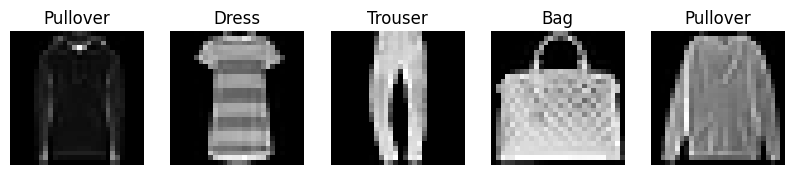

In [3]:
labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
              5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}

figure = plt.figure(figsize=(10, 5))
for i in range(1, 6):
    img, label = train_data[i]
    figure.add_subplot(1, 5, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 2. Model 1: Sığ Çok Katmanlı Algılayıcı (MLP)
Bu model, verideki uzamsal bilgileri (pixel komşuluklarını) dikkate almadan, görüntüyü düz bir vektöre (784 birim) dönüştürerek işler.

* **Mimari:** 1 Giriş katmanı (Flatten), 1 Gizli katman (128 Nöron - ReLU) ve 1 Çıkış katmanı (10 Sınıf - Softmax/Logits).
* **Amaç:** CNN modelleri için bir başarı alt sınırı (baseline) oluşturmak.

In [4]:
class Model1_MLP(nn.Module):
    def __init__(self):
        super(Model1_MLP, self).__init__()
        self.flatten = nn.Flatten()
        # 28x28 = 784 girişten 128 nöronlu gizli katmana
        self.fc1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        # 128 nörondan 10 çıkış sınıfına
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x shape: [batch_size, 1, 28, 28]
        x = self.flatten(x) # [batch_size, 784]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Modeli oluşturma ve özetini görme
model1 = Model1_MLP()
print(model1)

# Parametre sayısını görmek için (Hocanın istediği Model Summary)
from torchsummary import summary
summary(model1, (1, 28, 28))

Model1_MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


In [5]:
def train_model(model, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        # EĞİTİM AŞAMASI
        model.train()
        train_loss, correct = 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

        # VALIDASYON AŞAMASI
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()

        # Kayıtlar
        history['train_loss'].append(train_loss/len(train_loader))
        history['val_loss'].append(val_loss/len(val_loader))
        history['train_acc'].append(correct/len(train_data))
        history['val_acc'].append(val_correct/len(val_data))

        print(f"Epoch [{epoch+1}/{epochs}] - Train Acc: {history['train_acc'][-1]:.4f} - Val Acc: {history['val_acc'][-1]:.4f}")

    return history

# Model 1'i Eğit
print("Model 1 (MLP) Eğitimi Başlıyor...")
history1 = train_model(model1, train_loader, val_loader, epochs=10)

Model 1 (MLP) Eğitimi Başlıyor...
Epoch [1/10] - Train Acc: 0.8022 - Val Acc: 0.8405
Epoch [2/10] - Train Acc: 0.8525 - Val Acc: 0.8495
Epoch [3/10] - Train Acc: 0.8653 - Val Acc: 0.8585
Epoch [4/10] - Train Acc: 0.8728 - Val Acc: 0.8541
Epoch [5/10] - Train Acc: 0.8827 - Val Acc: 0.8775
Epoch [6/10] - Train Acc: 0.8852 - Val Acc: 0.8767
Epoch [7/10] - Train Acc: 0.8916 - Val Acc: 0.8762
Epoch [8/10] - Train Acc: 0.8965 - Val Acc: 0.8772
Epoch [9/10] - Train Acc: 0.9002 - Val Acc: 0.8855
Epoch [10/10] - Train Acc: 0.9042 - Val Acc: 0.8789


## 3. Model 2: Standart Evrişimli Sinir Ağı (CNN)
Bu modelde, görüntünün uzamsal (spatial) özelliklerini korumak için Evrişim (Convolution) katmanları kullanılmıştır. Bu katmanlar ile lokal ve uzamsal özellikler öğrenilmekte, MaxPooling katmanları ile boyut indirgeme ve çeviri dayanıklılığı sağlanmaktadır.

* **Mimari:** * 2 adet Conv katmanı (32 ve 64 filtre).
    * Max Pooling katmanları (Boyut küçültme ve önemli özellikleri seçme için).
    * ReLU aktivasyon fonksiyonu.
    * Son aşamada tam bağlı (Dense) bir çıkış katmanı.
* **Beklenti:** MLP modeline göre daha az parametre ile daha yüksek doğruluk (accuracy) elde edilmesi.

In [6]:
class Model2_CNN(nn.Module):
    def __init__(self):
        super(Model2_CNN, self).__init__()
        # İlk evrişim bloğu: Giriş 1 kanal (SB), çıkış 32 kanal. Filtre boyutu 3x3.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 28x28 -> 14x14

        # İkinci evrişim bloğu: 32 kanaldan 64 kanala.
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Pool sonrası: 14x14 -> 7x7

        # Tam bağlı katman (FC)
        # 64 kanal x 7x7 piksel = 3136 giriş
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Katman geçişleri ve print ile boyut kontrolü (Opsiyonel)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        x = x.view(-1, 64 * 7 * 7) # Düzleştirme (Flatten)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Modeli oluşturma ve özet
model2 = Model2_CNN()
summary(model2, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 1.61
Estimated Total Size (MB): 2.26
-------------------------------------------

In [7]:
print("Model 2 (Standart CNN) Eğitimi Başlıyor...")
history2 = train_model(model2, train_loader, val_loader, epochs=10)

Model 2 (Standart CNN) Eğitimi Başlıyor...
Epoch [1/10] - Train Acc: 0.8164 - Val Acc: 0.8738
Epoch [2/10] - Train Acc: 0.8874 - Val Acc: 0.8954
Epoch [3/10] - Train Acc: 0.9030 - Val Acc: 0.8993
Epoch [4/10] - Train Acc: 0.9138 - Val Acc: 0.9105
Epoch [5/10] - Train Acc: 0.9231 - Val Acc: 0.9100
Epoch [6/10] - Train Acc: 0.9294 - Val Acc: 0.9079
Epoch [7/10] - Train Acc: 0.9374 - Val Acc: 0.9208
Epoch [8/10] - Train Acc: 0.9423 - Val Acc: 0.9198
Epoch [9/10] - Train Acc: 0.9498 - Val Acc: 0.9237
Epoch [10/10] - Train Acc: 0.9552 - Val Acc: 0.9226


## 4. Model 3: Derin ve Düzenlenmiş CNN (Dropout & Batch Norm)
Bu model, Model 2'nin üzerine kapasite artırımı ve "Regularization" (Düzenlileştirme) teknikleri eklenerek geliştirilmiştir.

* **Batch Normalization:** Her katmandaki veriyi normalize ederek eğitimin çok daha hızlı ve kararlı (stable) olmasını sağlar.
* **Dropout:** Eğitim sırasında nöronların bir kısmını rastgele kapatarak modelin belirli nöronlara bağımlı kalmasını (ezberlemesini) engeller.
* **Derinlik:** Katman sayısı artırılarak modelin daha karmaşık desenleri öğrenmesi hedeflenmiştir.

In [8]:
class Model3_DeepCNN(nn.Module):
    def __init__(self):
        super(Model3_DeepCNN, self).__init__()

        # 1. Blok
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # 2. Blok
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout_conv = nn.Dropout2d(0.25)
        self.dropout_fc = nn.Dropout(0.5)

        # FC Katmanları
        # 28x28 -> Pool1 -> 14x14 -> Pool2 -> 7x7
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Blok 1
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x) # 14x14
        x = self.dropout_conv(x)

        # Blok 2
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x) # 7x7
        x = self.dropout_conv(x)

        # Fully Connected
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.bn4(self.fc1(x)))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

# Modeli oluşturma ve özet
model3 = Model3_DeepCNN()
summary(model3, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           9,248
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
         MaxPool2d-7           [-1, 32, 14, 14]               0
         Dropout2d-8           [-1, 32, 14, 14]               0
            Conv2d-9           [-1, 64, 14, 14]          18,496
      BatchNorm2d-10           [-1, 64, 14, 14]             128
             ReLU-11           [-1, 64, 14, 14]               0
        MaxPool2d-12             [-1, 64, 7, 7]               0
        Dropout2d-13             [-1, 64, 7, 7]               0
           Linear-14                  [

In [9]:
print("Model 3 (Gelişmiş CNN) Eğitimi Başlıyor...")
history3 = train_model(model3, train_loader, val_loader, epochs=10)

Model 3 (Gelişmiş CNN) Eğitimi Başlıyor...
Epoch [1/10] - Train Acc: 0.8421 - Val Acc: 0.8977
Epoch [2/10] - Train Acc: 0.8871 - Val Acc: 0.9098
Epoch [3/10] - Train Acc: 0.9013 - Val Acc: 0.9130
Epoch [4/10] - Train Acc: 0.9081 - Val Acc: 0.9238
Epoch [5/10] - Train Acc: 0.9151 - Val Acc: 0.9252
Epoch [6/10] - Train Acc: 0.9187 - Val Acc: 0.9301
Epoch [7/10] - Train Acc: 0.9243 - Val Acc: 0.9270
Epoch [8/10] - Train Acc: 0.9293 - Val Acc: 0.9331
Epoch [9/10] - Train Acc: 0.9326 - Val Acc: 0.9315
Epoch [10/10] - Train Acc: 0.9352 - Val Acc: 0.9334


## 5. Deneysel Sonuçlar ve Grafik Analizi
Bu bölümde, üç farklı modelin eğitim sürecindeki **Loss (Kayıp)** ve **Accuracy (Doğruluk)** değerleri karşılaştırılacaktır.

* **Loss Grafiği:** Modelin hatalarını ne kadar hızlı azalttığını gösterir.
* **Accuracy Grafiği:** Modelin doğru tahmin oranının zamanla değişimini gösterir.

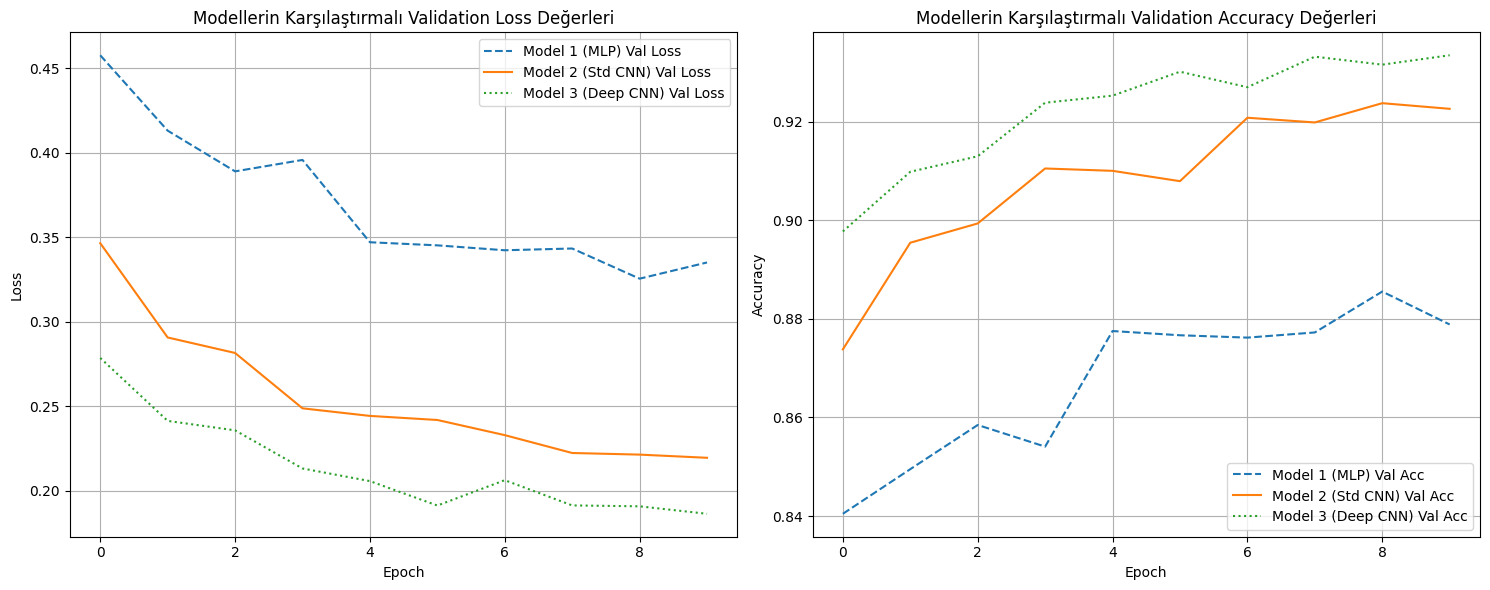

In [10]:
plt.figure(figsize=(15, 6))

# --- 1. LOSS GRAFİĞİ ---
plt.subplot(1, 2, 1)
plt.plot(history1['val_loss'], label='Model 1 (MLP) Val Loss', linestyle='--')
plt.plot(history2['val_loss'], label='Model 2 (Std CNN) Val Loss', linestyle='-')
plt.plot(history3['val_loss'], label='Model 3 (Deep CNN) Val Loss', linestyle=':')
plt.title('Modellerin Karşılaştırmalı Validation Loss Değerleri')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- 2. ACCURACY GRAFİĞİ ---
plt.subplot(1, 2, 2)
plt.plot(history1['val_acc'], label='Model 1 (MLP) Val Acc', linestyle='--')
plt.plot(history2['val_acc'], label='Model 2 (Std CNN) Val Acc', linestyle='-')
plt.plot(history3['val_acc'], label='Model 3 (Deep CNN) Val Acc', linestyle=':')
plt.title('Modellerin Karşılaştırmalı Validation Accuracy Değerleri')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Eğitim sürecinde model parametreleri accuracy’ye göre değil, Cross-Entropy loss fonksiyonunun minimize edilmesiyle güncellenmiştir; accuracy yalnızca performans değerlendirme metriği olarak kullanılmıştır. Bu nedenle grafiklerde loss eğrileri öğrenme sürecinin yönünü belirlerken, accuracy eğrileri modelin genel doğruluk seviyesini izlemek amacıyla sunulmuştur.

## 6. Shape Debugging (Boyut Kontrolü)
Olası “shape mismatch” hatalarını önlemek için her model, (2, 1, 28, 28) boyutunda bir dummy input ile çalıştırılmıştır.

- **Model 1 (MLP):** `Flatten` ile (1×28×28)=784 boyutlu vektöre dönüştürülür → `Linear` katmanlar 1D giriş beklediği için zorunludur.
- **Model 2 (CNN):** Pooling ile 28→14→7 boyut indirgenir; son conv çıktısı (64, 7, 7) olduğundan `Linear` giriş boyutu 64×7×7=3136’dır.
- **Model 3 (Deep CNN):** BatchNorm ve Dropout boyutu değiştirmez; yalnızca eğitimi stabilize eder ve overfitting’i azaltır.


In [15]:
import torch
import torch.nn as nn

# device project.ipynb'de yoksa bile bu hücre içinde tanımlıyoruz
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

def shape_debug(model, name, input_shape=(2, 1, 28, 28)):
    print(f"\n==============================")
    print(f" {name} - Shape Debug")
    print(f"==============================")

    model = model.to(device)
    model.eval()

    x = torch.randn(*input_shape, device=device)
    print("Input :", x.shape)

    # İsteğe bağlı: Katman katman ara boyutları yazdırmak için hook
    hooks = []
    def hook_fn(module, inp, out):
        # Sadece sık kullanılan katmanlarda yazdır (çıktıyı kalabalıklaştırmamak için)
        keep = (nn.Conv2d, nn.MaxPool2d, nn.Linear, nn.BatchNorm2d, nn.Dropout, nn.Flatten, nn.ReLU)
        if isinstance(module, keep):
            in_shape = inp[0].shape if isinstance(inp, (tuple, list)) and len(inp) > 0 else None
            out_shape = out.shape if hasattr(out, "shape") else type(out)
            print(f"{module.__class__.__name__:12s} | in {in_shape} -> out {out_shape}")

    for m in model.modules():
        # Çok temel container'lar yerine gerçek katmanlara hook takalım
        if isinstance(m, (nn.Conv2d, nn.MaxPool2d, nn.Linear, nn.BatchNorm2d, nn.Dropout, nn.Flatten, nn.ReLU)):
            hooks.append(m.register_forward_hook(hook_fn))

    with torch.no_grad():
        y = model(x)

    # hook'ları temizle
    for h in hooks:
        h.remove()

    print("Output:", y.shape)

# project.ipynb'deki model isimleriyle birebir:
shape_debug(model1, "Model 1 (MLP)")
shape_debug(model2, "Model 2 (CNN)")
shape_debug(model3, "Model 3 (Deep CNN)")


device: cpu

 Model 1 (MLP) - Shape Debug
Input : torch.Size([2, 1, 28, 28])
Flatten      | in torch.Size([2, 1, 28, 28]) -> out torch.Size([2, 784])
Linear       | in torch.Size([2, 784]) -> out torch.Size([2, 128])
ReLU         | in torch.Size([2, 128]) -> out torch.Size([2, 128])
Linear       | in torch.Size([2, 128]) -> out torch.Size([2, 10])
Output: torch.Size([2, 10])

 Model 2 (CNN) - Shape Debug
Input : torch.Size([2, 1, 28, 28])
Conv2d       | in torch.Size([2, 1, 28, 28]) -> out torch.Size([2, 32, 28, 28])
ReLU         | in torch.Size([2, 32, 28, 28]) -> out torch.Size([2, 32, 28, 28])
MaxPool2d    | in torch.Size([2, 32, 28, 28]) -> out torch.Size([2, 32, 14, 14])
Conv2d       | in torch.Size([2, 32, 14, 14]) -> out torch.Size([2, 64, 14, 14])
ReLU         | in torch.Size([2, 64, 14, 14]) -> out torch.Size([2, 64, 14, 14])
MaxPool2d    | in torch.Size([2, 64, 14, 14]) -> out torch.Size([2, 64, 7, 7])
Linear       | in torch.Size([2, 3136]) -> out torch.Size([2, 128])
ReLU  

#### Shape Debug Çıktılarının Yorumu

- **Model 1 (MLP):** Giriş görüntüsü `(1×28×28)` boyutundan `Flatten` katmanı ile `784` boyutlu vektöre dönüştürülmüştür. Bu adım, fully connected (`Linear`) katmanların yalnızca 1 boyutlu giriş kabul etmesi nedeniyle zorunludur.

- **Model 2 (CNN):** Konvolüsyon ve `2×2` max-pooling katmanları sonrası uzamsal boyutlar `28 → 14 → 7` şeklinde küçülmüştür. Kanal sayısı `64` olduğundan, fully connected katmana giriş boyutu `64 × 7 × 7 = 3136` olarak hesaplanmıştır.

- **Model 3 (Deep CNN):** Batch Normalization ve Dropout katmanları tensör boyutunu değiştirmemekte; BatchNorm eğitim sürecini stabilize ederken, Dropout overfitting’i azaltmak amacıyla regularization sağlamaktadır.

- Tüm modellerde çıktı boyutunun `(batch_size, 10)` olması, ağların 10 sınıflı sınıflandırma problemi için doğru şekilde yapılandırıldığını göstermektedir.


## 7. Hata Analizi ve Model Performansının Değerlendirilmesi
Bu bölümde, en başarılı modelimizin olan Model 3'ün performansını detaylandıracağız.
* **Confusion Matrix:** Hangi sınıfların birbiriyle karıştırıldığını analiz eder.
* **Hatalı Tahmin Analizi:** Modelin çok yüksek güvenle (confidence) yanlış bildiği örnekler incelenerek hatanın kök nedeni (benzerlik, gürültü vb.) tartışılacaktır.

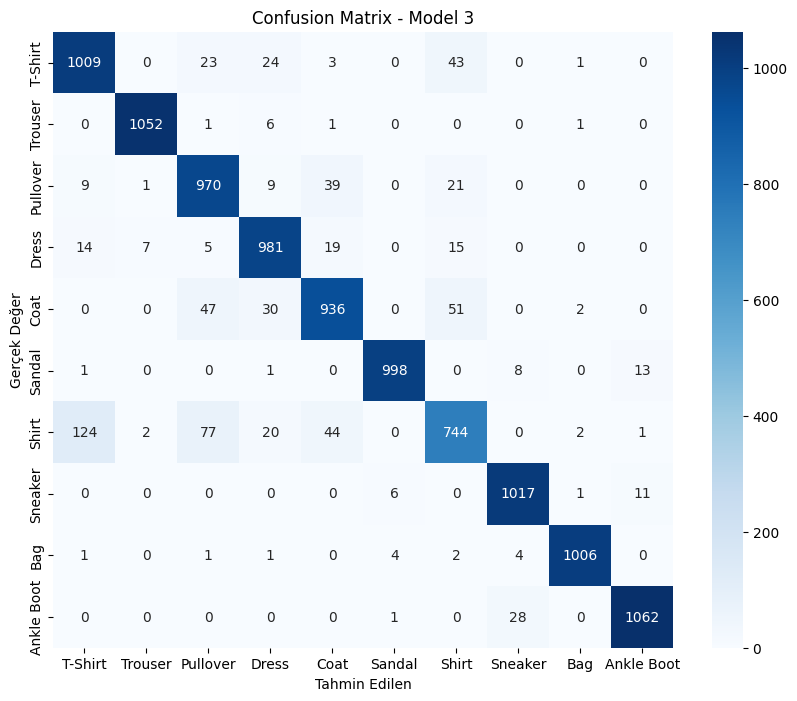


Sınıflandırma Raporu:

              precision    recall  f1-score   support

     T-Shirt       0.87      0.91      0.89      1103
     Trouser       0.99      0.99      0.99      1061
    Pullover       0.86      0.92      0.89      1049
       Dress       0.92      0.94      0.93      1041
        Coat       0.90      0.88      0.89      1066
      Sandal       0.99      0.98      0.98      1021
       Shirt       0.85      0.73      0.79      1014
     Sneaker       0.96      0.98      0.97      1035
         Bag       0.99      0.99      0.99      1019
  Ankle Boot       0.98      0.97      0.98      1091

    accuracy                           0.93     10500
   macro avg       0.93      0.93      0.93     10500
weighted avg       0.93      0.93      0.93     10500



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_map.values(),
                yticklabels=labels_map.values())
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek Değer')
    plt.title('Confusion Matrix - Model 3')
    plt.show()

    # Rapor için gerekli metrikler (Precision, Recall, F1)
    print("\nSınıflandırma Raporu:\n")
    print(classification_report(y_true, y_pred, target_names=list(labels_map.values())))

plot_confusion_matrix(model3, test_loader)

Modelin En Çok Yanıldığı (En Emin Olduğu Hatalar):


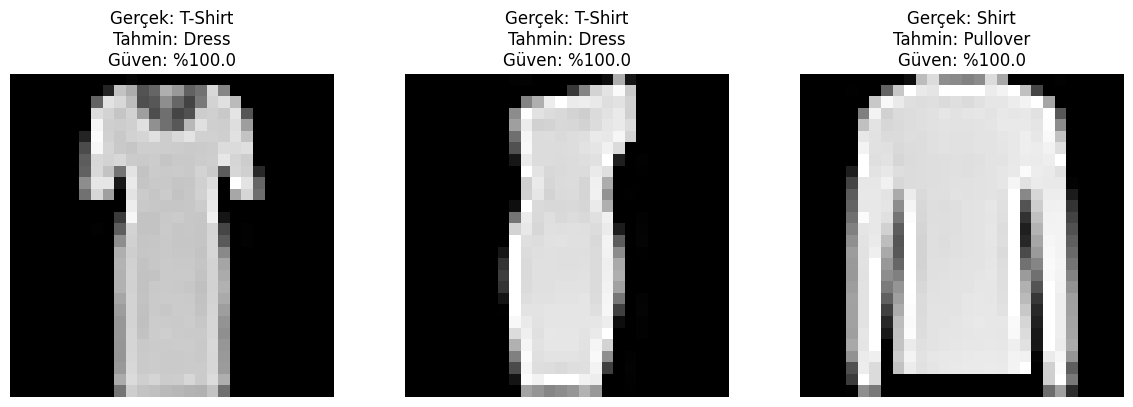

In [14]:
def show_top_errors(model, loader, n=3):
    model.eval()
    errors = []

    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            conf, predicted = torch.max(probs, 1)

            # Yanlış tahminleri filtrele
            mask = predicted != labels
            for img, p, c, l in zip(images[mask], predicted[mask], conf[mask], labels[mask]):
                errors.append((img, p.item(), c.item(), l.item()))

    # Güvene (confidence) göre sırala (En yüksek güvenle yanlış bildikleri)
    errors.sort(key=lambda x: x[2], reverse=True)

    plt.figure(figsize=(12, 4))
    for i in range(min(n, len(errors))):
        img, pred, conf, true = errors[i]
        plt.subplot(1, n, i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"Gerçek: {labels_map[true]}\nTahmin: {labels_map[pred]}\nGüven: %{conf*100:.1f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Modelin En Çok Yanıldığı (En Emin Olduğu Hatalar):")
show_top_errors(model3, test_loader)